# Coronavirus tweets NLP - Text Classification

## Loading useful libraries and modules

In [1]:
import io
import random
import re
import string
import unidecode

from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

In [2]:
# Set the pandas display
pd.set_option('display.max_colwidth', None)

def set_seeds(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds()

## Loading data and performing exploratory data analysis

In [3]:
usecols = ['OriginalTweet', 'Sentiment']

# Load raw train data
train_data = pd.read_csv('./data/Corona_NLP_train.csv', usecols=usecols)
print(f'The training data has {train_data.shape[0]:,} rows and {train_data.shape[1]} colums')

# Load raw test data
test_data = pd.read_csv('./data/Corona_NLP_test.csv', usecols=usecols)
print(f'The testing data has {test_data.shape[0]:,} rows and {test_data.shape[1]} columns')

The training data has 41,157 rows and 2 colums
The testing data has 3,798 rows and 2 columns


## Plotting the target distribution

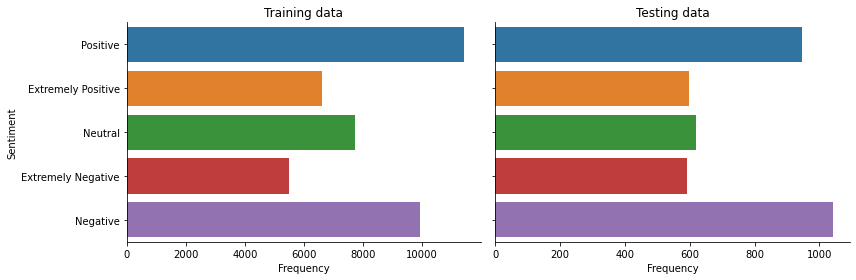

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

order = ['Positive', 'Extremely Positive', 'Neutral', 'Extremely Negative', 'Negative']

sns.countplot(y='Sentiment', data=train_data, order=order, ax=ax[0])
ax[0].set(xlabel='Frequency', ylabel='Sentiment', title='Training data')

sns.countplot(y='Sentiment', data=test_data, order=order, ax=ax[1])
ax[1].set(xlabel='Frequency', ylabel=None, title='Testing data')

sns.despine()
plt.tight_layout();


## Preprocessing raw text data for classification

In [5]:
# Regular expressions
remove_urls     = re.compile(r'https?://\S+|www\.\S+')
remove_hashtags = re.compile(r'#\w+')
remove_emails   = re.compile(r'\S+@\S+')
remove_rt       = re.compile(r'^RT[\s]+')
remove_numbers  = re.compile(r'\d+')

# Load punctuation
punctuation = string.punctuation

# Instantiate TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False,  # lowercasing
                       strip_handles=True,   # remove handles
                       reduce_len=True)      # reduce repetition


def preprocess_text(text):

    # Apply regex
    text = remove_urls.sub('', text)  # remove urls

    # Parse HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    text = remove_emails.sub('', text)    # remove emails
    text = remove_hashtags.sub('', text)  # remove hashtags    
    text = remove_rt.sub('', text)        # remove RT
    
    # Encoding-decoding text
    text = text.encode('ascii', 'replace').decode('utf-8') 

    # Tokenization
    tokens = tknzr.tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and len(token) > 1]
    
    return ' '.join(tokens)

In [6]:
print('\033[94m', 'Original text', '-' * 14, train_data.loc[40370, "OriginalTweet"], '', 
      '\033[92m', 'Preprocessed text', '-' * 18,  preprocess_text(train_data.loc[40370, "OriginalTweet"]), sep='\n')


Original text
--------------
We created an interactive map of direct-to-consumer brands based in NYC to illustrate the true creative energy of the city, the way it was before coronavirus and the way it will return soon. - Chris Nager @airHQ #Covid19 https://t.co/STND1yS2Ry #builtwithmapbox #NYCstrong https://t.co/C540HeBTYx


Preprocessed text
------------------
we created an interactive map of brands based in nyc to illustrate the true creative energy of the city the way it was before coronavirus and the way it will return soon chris nager


In [7]:
%%time
train_data['tweet'] = train_data['OriginalTweet'].apply(preprocess_text)
test_data['tweet'] = test_data['OriginalTweet'].apply(preprocess_text)

Wall time: 15.4 s


In [8]:
train_data.head()

,OriginalTweet,Sentiment,tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,and and
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,my food stock is not the only one which is empty please panic there will be enough food for everyone if you do not take more than you need stay calm stay safe
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,me ready to go at supermarket during the outbreak not because paranoid but because my food stock is litteraly empty the is serious thing but please panic it causes shortage


## Dealing with missing values after preprocessing raw text data

In [9]:
train_data.loc[train_data['tweet'] == '', ['tweet']]= np.nan
test_data.loc[test_data['tweet'] == '', ['tweet']]= np.nan

print('Missing values in traing data', '-' * 30 , train_data.isna().sum(), 
      '\nMissing values in testing data', '-' * 30, test_data.isna().sum(), sep='\n')

Missing values in traing data
------------------------------
OriginalTweet     0
Sentiment         0
tweet            39
dtype: int64

Missing values in testing data
------------------------------
OriginalTweet    0
Sentiment        0
tweet            2
dtype: int64


In [10]:
# Remove missing values
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Sanity check
print('Missing values in traing data', '-' * 30 , train_data.isna().sum(), 
      '\nMissing values in testing data', '-' * 30, test_data.isna().sum(), sep='\n')

Missing values in traing data
------------------------------
OriginalTweet    0
Sentiment        0
tweet            0
dtype: int64

Missing values in testing data
------------------------------
OriginalTweet    0
Sentiment        0
tweet            0
dtype: int64


## Preprocessing labels

In [11]:
target_names = {
    'Extremely Negative': 'Negative',
    'Extremely Positive': 'Positive',
}

train_data['Sentiment'].replace(target_names, inplace=True)
test_data['Sentiment'].replace(target_names, inplace=True)

## New target distribution

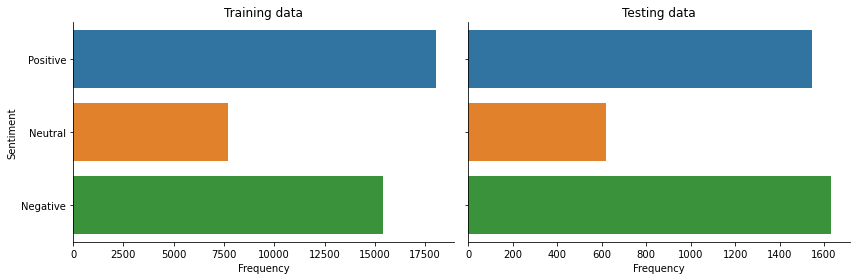

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

order = ['Positive', 'Neutral', 'Negative']

sns.countplot(y='Sentiment', data=train_data, order=order, ax=ax[0])
ax[0].set(xlabel='Frequency', ylabel='Sentiment', title='Training data')

sns.countplot(y='Sentiment', data=test_data, order=order, ax=ax[1])
ax[1].set(xlabel='Frequency', ylabel=None, title='Testing data')

sns.despine()
plt.tight_layout();

## Word frequency

In [13]:
# Compute the word frequency
corpus = ' '.join(train_data['tweet'])
fdist = nltk.FreqDist(word_tokenize(corpus))

In [14]:
pprint(fdist.most_common(50), compact=True)

[('the', 44857), ('to', 38365), ('and', 24079), ('of', 21518), ('in', 19163),
 ('for', 14059), ('is', 12264), ('are', 11351), ('covid', 10613), ('you', 9625),
 ('on', 9410), ('this', 7987), ('prices', 7847), ('at', 7789), ('food', 6835),
 ('store', 6820), ('supermarket', 6700), ('with', 6637), ('we', 6553),
 ('it', 6453), ('that', 6443), ('have', 6156), ('as', 6111), ('grocery', 6087),
 ('be', 5752), ('people', 5549), ('from', 5293), ('all', 4888), ('not', 4773),
 ('your', 4601), ('will', 4501), ('can', 4386), ('consumer', 4298),
 ('my', 4206), ('our', 4052), ('they', 4012), ('has', 3804), ('out', 3793),
 ('up', 3788), ('or', 3736), ('by', 3724), ('more', 3719), ('but', 3570),
 ('if', 3555), ('shopping', 3371), ('online', 3353), ('how', 3331),
 ('their', 3227), ('during', 3205), ('now', 3104)]


In [15]:
train_data['word_count'] = train_data['tweet'].apply(lambda row: len(row.split()))

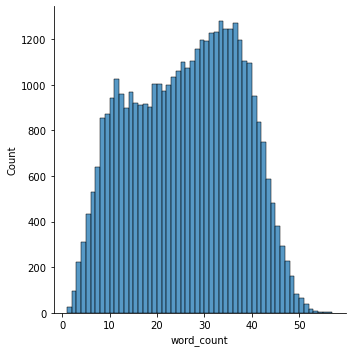

In [16]:
bins = [*set(train_data['word_count'])]
sns.displot(x='word_count',
            bins=bins,
            data=train_data);

## Preparing data

In [17]:
# Text tokenization
tokenizer = Tokenizer(oov_token='<UNK>') 
tokenizer.fit_on_texts(train_data['tweet'])

word_index = tokenizer.word_index

In [18]:
pad_sequences_args = {'maxlen': 50, 
                      'padding': 'post',
                      'truncating': 'post'}

# Transforms each text in texts to a sequence of integers
X_train_seq = tokenizer.texts_to_sequences(train_data['tweet'])
X_test_seq = tokenizer.texts_to_sequences(test_data['tweet'])

# Pads sequences to the same length
X_train =  pad_sequences(X_train_seq, **pad_sequences_args)
X_test = pad_sequences(X_test_seq, **pad_sequences_args)

In [19]:
print('Text', '-' * 5, train_data.loc[2, 'tweet'],
    '\nVector', '-' * 7, X_train[2], sep='\n')

Text
-----
coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak

Vector
-------
[  76  871 4230    3  295  306 1375 1711   46  252  151   10  130    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [20]:
le = LabelEncoder()
y_train = le.fit_transform(train_data['Sentiment'])
y_test  = le.fit_transform(test_data['Sentiment'])

target_names = le.classes_

# Sanity check
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((41118, 50), (41118,), (3796, 50), (3796,))

## Loading [fastText](https://fasttext.cc/docs/en/english-vectors.html) pre-trained word embeddings

In [21]:
%%time

embeddings_index = {}

with io.open('./crawl-300d-2M.vec', 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index):,} word vectors.')
print('---\n')

Found 1,999,996 word vectors.
---

Wall time: 4min 52s


In [22]:
# Prepare the fastText word-embeddings matrix
vocab_size = len(word_index) + 1
embedding_dim = 300

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(f'Embeddings matrix dimensions: {embeddings_matrix.shape[0]:,} rows and {embeddings_matrix.shape[1]} columns')

Embeddings matrix dimensions: 31,917 rows and 300 columns


## Training and validation the model

In [23]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([

        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  input_length=X_train.shape[1],
                                  weights=[embeddings_matrix],
                                  trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                           dropout=0.3,
                                                           return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                           dropout=0.3,
                                                           return_sequences=True)),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           9575100   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 600)           1442400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 600)           2162400   
_________________________________________________________________
global_max_pooling1d (Global (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               153856    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7

In [24]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=1),

    tf.keras.callbacks.ModelCheckpoint('best_model.h5',                                       
                                       save_best_only=True),
                                         
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                     patience=12,
                                     verbose=1, 
                                     restore_best_weights=True)
]

class_weight_ = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train), 
                                                  y=y_train)
class_weight_

array([0.89017341, 1.78533281, 0.75958767])

In [25]:
%%time
history = model.fit(X_train,
                    y_train,
                    batch_size=64,
                    epochs=100,
                    callbacks=callbacks, 
                    validation_split=0.2,
                    class_weight=class_weight_,
                    workers=4,
                    use_multiprocessing=True)

Train on 32894 samples, validate on 8224 samples
Epoch 1/100
32894/32894 [==============================] - 92s 3ms/sample - loss: 0.6582 - accuracy: 0.7388 - val_loss: 0.3858 - val_accuracy: 0.8628
Epoch 2/100
32894/32894 [==============================] - 50s 2ms/sample - loss: 0.4088 - accuracy: 0.8544 - val_loss: 0.3115 - val_accuracy: 0.8914
Epoch 3/100
32894/32894 [==============================] - 45s 1ms/sample - loss: 0.3351 - accuracy: 0.8844 - val_loss: 0.2731 - val_accuracy: 0.9139
Epoch 4/100
32894/32894 [==============================] - 43s 1ms/sample - loss: 0.3053 - accuracy: 0.8974 - val_loss: 0.2789 - val_accuracy: 0.9097
Epoch 5/100
32894/32894 [==============================] - 45s 1ms/sample - loss: 0.2953 - accuracy: 0.8996 - val_loss: 0.2478 - val_accuracy: 0.9197
Epoch 6/100
32894/32894 [==============================] - 48s 1ms/sample - loss: 0.2780 - accuracy: 0.9063 - val_loss: 0.2604 - val_accuracy: 0.9199
Epoch 7/100
32894/32894 [==========================

## Plotting the results

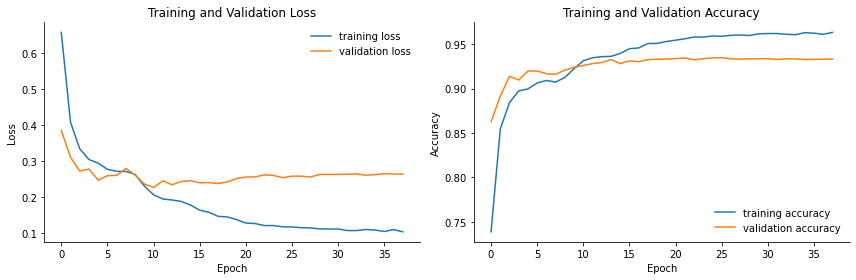

In [26]:
hist = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.ravel()

metrics = ['loss', 'accuracy']

for i, metric in enumerate(metrics):
    sns.lineplot(x=hist.index, y=f'{metric}', data=hist, ax=ax[i], label=f'training {metric}')
    sns.lineplot(x=hist.index, y=f'val_{metric}', data=hist, ax=ax[i], label=f'validation {metric}')
    ax[i].set(xlabel='Epoch', ylabel=f'{metric.title()}', title=f'Training and Validation {metric.title()}')
    ax[i].legend(frameon=False)

sns.despine()
plt.tight_layout();

## Evaluating the model

In [30]:
# Load the best model
model = tf.keras.models.load_model('best_model.h5')

_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 91.54%


## Confusion matrix

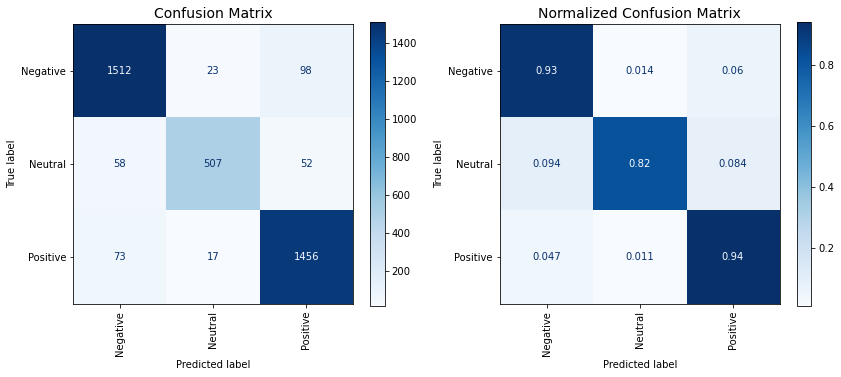

In [28]:
# Predictions
preds = np.argmax(model.predict(X_test), axis=1)

# Plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot(cmap='Blues', xticks_rotation='vertical', ax=ax[0])
ax[0].set_title('Confusion Matrix', fontsize=14)

cm_norm = confusion_matrix(y_test, preds, normalize='true')
ConfusionMatrixDisplay(cm_norm, display_labels=target_names).plot(cmap='Blues', xticks_rotation='vertical', ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix', fontsize=14)

plt.tight_layout();

## Classification report

In [29]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.92      0.93      0.92      1633
     Neutral       0.93      0.82      0.87       617
    Positive       0.91      0.94      0.92      1546

    accuracy                           0.92      3796
   macro avg       0.92      0.90      0.91      3796
weighted avg       0.92      0.92      0.91      3796



Referências:

https://cce.puc-rio.br/sitecce/website/website.dll/folder?nCurso=bi-master-(traco)-business-intelligence-master-(traco)-sistemas-inteligentes-de-apoio-a-decisao-em-negocios&nInst=cce   
https://github.com/rrfsantos/Desafios-NLP   
https://www.kaggle.com/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc   

